Shape: (1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cement                       1030 non-null   float64
 1   BlastFurnaceSlag             1030 non-null   float64
 2   FlyAsh                       1030 non-null   float64
 3   Water                        1030 non-null   float64
 4   Superplasticizer             1030 non-null   float64
 5   CoarseAggregate              1030 non-null   float64
 6   FineAggregate                1030 non-null   float64
 7   Age                          1030 non-null   int64  
 8   ConcreteCompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None
                              count        mean         std         min  \
Cement                       1030.0  281.165631  104.507142  102.000000   
BlastFurnaceSlag             1030.0   73.895485   

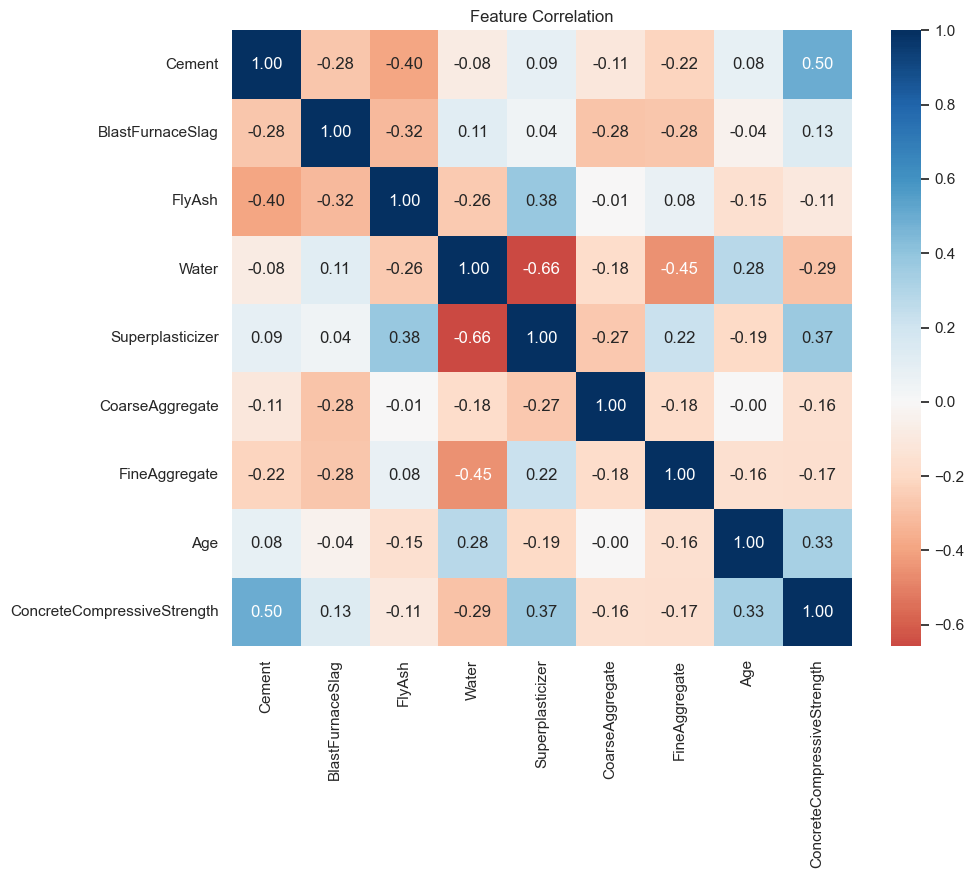

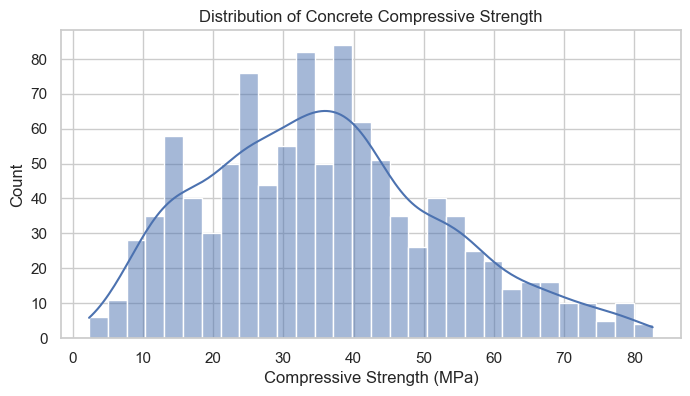

Train shape: (824, 8) Test shape: (206, 8)
LinearRegression → test_rmse: 9.797, test_r2: 0.628, cv_rmse: 10.665
Ridge → test_rmse: 9.796, test_r2: 0.628, cv_rmse: 10.664
RandomForestRegressor → test_rmse: 5.517, test_r2: 0.882, cv_rmse: 5.136
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned RF test RMSE: 5.554, MAE: 3.781, R2: 0.880
Feature importances:
 Age                 0.332842
Cement              0.324477
Water               0.123971
BlastFurnaceSlag    0.076236
Superplasticizer    0.058917
FineAggregate       0.035761
CoarseAggregate     0.027957
FlyAsh              0.019839
dtype: float64


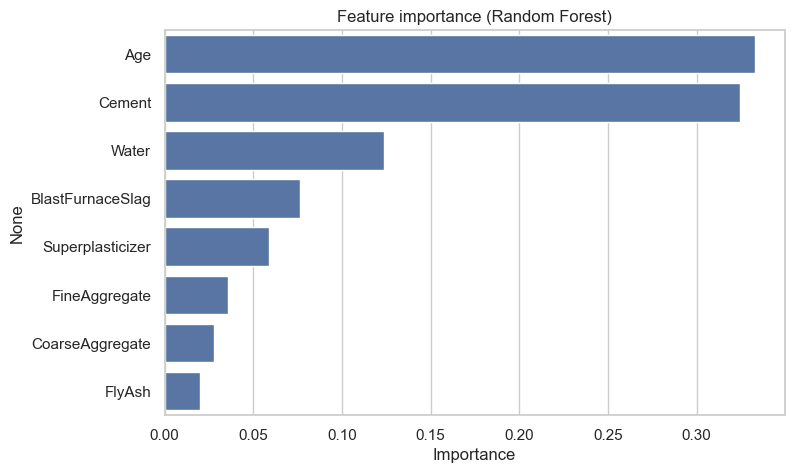

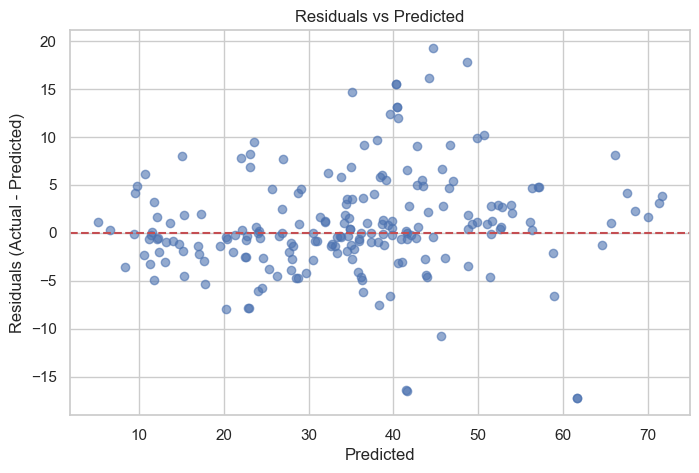

Saved model pipeline to concrete_rf_pipeline.joblib
Sample inputs:
      Cement  BlastFurnaceSlag  FlyAsh  Water  Superplasticizer  \
584   228.0             342.1     0.0  185.7              0.00   
535   393.0               0.0     0.0  192.0              0.00   
482   446.0              24.0    79.0  162.0             11.64   

     CoarseAggregate  FineAggregate  Age  
584            955.8          674.3    7  
535            940.6          785.6   90  
482            967.0          712.0   56  
Predictions: [22.64805589 43.36015772 54.05025434]
SHAP not available or failed: No module named 'shap'
Saved predictions to concrete_predictions_test.csv


In [1]:
# %% [1] Imports and settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

# %% [2] Load dataset (expects Concrete_Data.xls in same folder)
data_path = "Concrete_Data.xls"  # or Concrete_Data.csv if you converted it
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"{data_path} not found. Download from UCI: https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength and save as {data_path}"
    )

# read excel
df = pd.read_excel(data_path)
# If you have a CSV, use pd.read_csv('Concrete_Data.csv')

# show top rows
print("Shape:", df.shape)
display(df.head())

# Column names (UCI dataset has these columns)
df.columns = [
    "Cement",
    "BlastFurnaceSlag",
    "FlyAsh",
    "Water",
    "Superplasticizer",
    "CoarseAggregate",
    "FineAggregate",
    "Age",
    "ConcreteCompressiveStrength"
]

# %% [3] Quick EDA
print(df.info())
print(df.describe().T)

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Pairwise correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title("Feature Correlation")
plt.show()

# Distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df["ConcreteCompressiveStrength"], kde=True, bins=30)
plt.title("Distribution of Concrete Compressive Strength")
plt.xlabel("Compressive Strength (MPa)")
plt.show()

# %% [4] Train-test split
X = df.drop(columns=["ConcreteCompressiveStrength"])
y = df["ConcreteCompressiveStrength"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# %% [5] Baseline models in a pipeline (StandardScaler + model)
def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5):
    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # cross-val RMSE on training set
    cv_scores = -cross_val_score(pipe, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=cv)
    cv_rmse = np.sqrt(cv_scores).mean()
    return {
        "model": model.__class__.__name__,
        "test_rmse": rmse,
        "test_mae": mae,
        "test_r2": r2,
        "cv_rmse": cv_rmse,
        "pipe": pipe
    }

models = [
    LinearRegression(),
    Ridge(alpha=1.0, random_state=RANDOM_STATE),
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
]

results = []
for m in models:
    res = evaluate_model(m, X_train, y_train, X_test, y_test)
    results.append(res)
    print(res["model"], "→ test_rmse: {:.3f}, test_r2: {:.3f}, cv_rmse: {:.3f}".format(
        res["test_rmse"], res["test_r2"], res["cv_rmse"]
    ))

# %% [6] Hyperparameter tuning for RandomForest
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 8, 12],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

pipe = Pipeline([("scaler", StandardScaler()), ("model", RandomForestRegressor(random_state=RANDOM_STATE))])
gsearch = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=1)
gsearch.fit(X_train, y_train)
print("Best params:", gsearch.best_params_)
best_pipe = gsearch.best_estimator_

# Evaluate tuned model
y_pred = best_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Tuned RF test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# %% [7] Feature importance (from RandomForest)
# Extract feature importances from the final RF
rf_model = best_pipe.named_steps["model"]
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Feature importances:\n", feat_imp)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

# %% [8] Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

# %% [9] Save final model and scaler pipeline
model_out_path = "concrete_rf_pipeline.joblib"
joblib.dump(best_pipe, model_out_path)
print(f"Saved model pipeline to {model_out_path}")

# %% [10] Quick inference example
sample = X_test.sample(3, random_state=RANDOM_STATE)
preds = best_pipe.predict(sample)
print("Sample inputs:\n", sample)
print("Predictions:", preds)

# %% [11] Optional: Explainability with SHAP (if installed)
# pip install shap
try:
    import shap
    explainer = shap.Explainer(best_pipe.named_steps["model"], best_pipe.named_steps["scaler"].transform(X_train))
    shap_values = explainer(best_pipe.named_steps["scaler"].transform(X_test))
    shap.summary_plot(shap_values, features=best_pipe.named_steps["scaler"].transform(X_test),
                      feature_names=X.columns, plot_type="bar")
except Exception as e:
    print("SHAP not available or failed:", e)

# %% [12] Optional: Save predictions to CSV
pred_df = X_test.copy()
pred_df["ActualStrength"] = y_test
pred_df["PredictedStrength"] = y_pred
pred_df.to_csv("concrete_predictions_test.csv", index=False)
print("Saved predictions to concrete_predictions_test.csv")
